In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
df=pd.read_csv('/content/gdrive/My Drive/Karachi_temp.csv')

In [ ]:
df.head()

,Region,Country,City,Month,Day,Year,AvgTemperature
0,Asia,Pakistan,Karachi,1,1,1995,66.4
1,Asia,Pakistan,Karachi,1,2,1995,66.9
2,Asia,Pakistan,Karachi,1,3,1995,63.1
3,Asia,Pakistan,Karachi,1,4,1995,63.5
4,Asia,Pakistan,Karachi,1,5,1995,63.0


In [ ]:
df.head()

,Region,Country,City,Month,Day,Year,AvgTemperature
0,Asia,Pakistan,Karachi,1,1,1995,66.4
1,Asia,Pakistan,Karachi,1,2,1995,66.9
2,Asia,Pakistan,Karachi,1,3,1995,63.1
3,Asia,Pakistan,Karachi,1,4,1995,63.5
4,Asia,Pakistan,Karachi,1,5,1995,63.0


In [ ]:
df.describe()

,Month,Day,Year,AvgTemperature
count,9265.000000,9265.000000,9265.000000,9265.000000
mean,6.469077,15.717647,2007.186832,77.936881
std,3.457480,8.801945,7.324542,21.842518
min,1.000000,1.000000,1995.000000,-99.000000
25%,3.000000,8.000000,2001.000000,73.800000
50%,6.000000,16.000000,2007.000000,83.000000
75%,9.000000,23.000000,2014.000000,86.300000
max,12.000000,31.000000,2020.000000,99.700000


In [ ]:
df.shape

(9265, 7)

In [ ]:
df=df.drop(['Region','Country','City'],axis=1)

In [ ]:
df.head()

,Month,Day,Year,AvgTemperature
0,1,1,1995,66.4
1,1,2,1995,66.9
2,1,3,1995,63.1
3,1,4,1995,63.5
4,1,5,1995,63.0


Dropping any duplicate rows and checking for Null values

In [ ]:
df = df.drop_duplicates()
df.isnull().sum()

Month             0
Day               0
Year              0
AvgTemperature    0
dtype: int64

Outliers are present and can be seen in the figure above. Let's choose all the rows having 'AvgTemperature' greater than 32°F

In [ ]:
df = df[df['AvgTemperature']>32]

Let's check the range of Year-Month-Day in the dataset

In [ ]:
df.sort_values(['Year','Month','Day'])

,Month,Day,Year,AvgTemperature
0,1,1,1995,66.4
1,1,2,1995,66.9
2,1,3,1995,63.1
3,1,4,1995,63.5
4,1,5,1995,63.0
...,...,...,...,...
9260,5,8,2020,88.8
9261,5,9,2020,87.7
9262,5,10,2020,87.8
9263,5,11,2020,87.8


In [ ]:
df["AvgTemperature"].min()

52.2

The data spans from Jan 1995 to May 2020

Since 2020 is incomplete, let's strip it off for the current analysis

In [ ]:
df = df[df['Year']<2020]

In [ ]:
df.tail()

,Month,Day,Year,AvgTemperature
9127,12,27,2019,63.1
9128,12,28,2019,65.0
9129,12,29,2019,62.6
9130,12,30,2019,61.1
9131,12,31,2019,60.7


Average temperature of the Karachi over the years 1995 to 2019

In [ ]:
data = df[['Year','AvgTemperature']].groupby('Year').mean()

In [ ]:
data

,AvgTemperature
Year,
1995,79.401370
1996,79.159178
1997,79.255956
1998,81.021111
1999,81.013569
2000,82.247557
2001,80.958904
2002,80.310803
2003,80.552877


Let's display the highest and lowest recorded temperature in this dataset (1995 to 2019)

In [ ]:
data1=df.sort_values(by=['AvgTemperature'],ascending=False).head(1)
data2=df.sort_values(by=['AvgTemperature'],ascending=True).head(1)
data = pd.concat([data1,data2],)
data.index = ['Highest','Lowest']
data

,Month,Day,Year,AvgTemperature
Highest,6,21,2015,99.7
Lowest,2,6,2008,52.2


In [ ]:
df['Date'] = df[['Year','Month','Day']].apply(lambda row:'-'.join([str(row['Year']),str(row['Month']),str(row['Day'])]),axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(columns=['Month','Day','Year']).set_index('Date')
df.head(3)

,AvgTemperature
Date,
1995-01-01,66.4
1995-01-02,66.9
1995-01-03,63.1


LSTM Model Creation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping


Train - Test - Split: Choosing 2019 data for testing and remaining for training

In [ ]:
test = df[df.index>'2019']
train = df[df.index<'2019']

In [ ]:
train

,AvgTemperature
Date,
1995-01-01,66.4
1995-01-02,66.9
1995-01-03,63.1
1995-01-04,63.5
1995-01-05,63.0
...,...
2018-12-27,66.5
2018-12-28,65.7
2018-12-29,63.8


Scaling train data and test data for LSTM Input

In [ ]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [ ]:
time_steps = 20
features = 1

train_gen = TimeseriesGenerator(train,train,time_steps,batch_size=32)
test_gen = TimeseriesGenerator(test,test,time_steps,batch_size=32)

Defining a sequential model

In [ ]:
model = Sequential()
model.add(LSTM(64,activation='relu',input_shape=(time_steps,features),return_sequences=True))
model.add(LSTM(32,activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(optimizer='adam',loss='mse')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 64)            16896     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(x=train_gen,epochs=20,validation_data=test_gen)

Epoch 1/20
270/270 [==============================] - 6s 15ms/step - loss: 0.0149 - val_loss: 0.0045
Epoch 2/20
270/270 [==============================] - 4s 16ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 3/20
270/270 [==============================] - 4s 14ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 4/20
270/270 [==============================] - 4s 13ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 5/20
270/270 [==============================] - 4s 14ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 6/20
270/270 [==============================] - 4s 13ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 7/20
270/270 [==============================] - 4s 16ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 8/20
270/270 [==============================] - 4s 13ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 9/20
270/270 [==============================] - 4s 14ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/20
270/270 [==============================] - 4s 15ms/step - loss: 0.0016 - val_lo

In [ ]:
#Save the model
model.save('LSTMAvgTemp.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Let's input X values in the test generator to the model and collect it's predictions

Let's also collect the original targets from the test generator

In [ ]:
predict = model.predict(test_gen)
test_targets = test_gen.targets[test_gen.start_index:test_gen.end_index+1]

11/11 [==============================] - 0s 4ms/step


Let's inverse transform the scaled results

In [ ]:
predict = scaler.inverse_transform(predict).ravel()
test_targets = scaler.inverse_transform(test_targets).ravel()

Model Evaluation
The predictions of the model for the year 2019 are plotted with the actual target values of 2019

In [ ]:
from sklearn.metrics import mean_squared_error

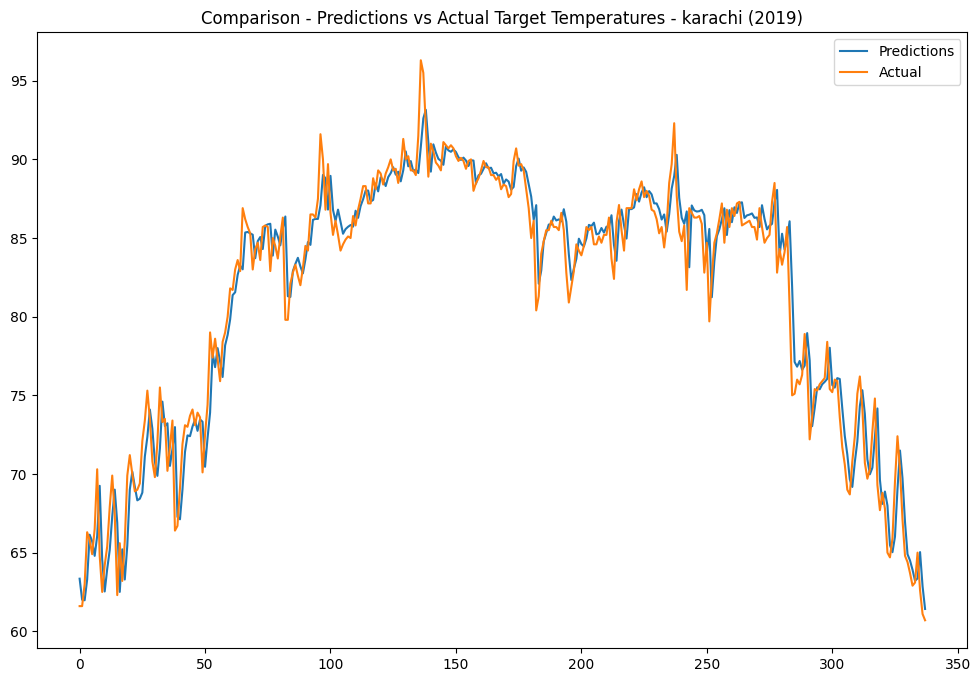

In [ ]:
_,ax=plt.subplots(1,1,figsize=(12,8))
sns.lineplot(x=range(len(predict)),y=predict,ax=ax,label='Predictions')
sns.lineplot(x=range(len(test_targets)),y=test_targets,ax=ax,label='Actual')
plt.legend()
_=plt.title('Comparison - Predictions vs Actual Target Temperatures - karachi (2019)')

In [ ]:
print('The RMSE Score is:',format(np.sqrt(mean_squared_error(predict,test_targets)),'.2f'))

The RMSE Score is: 1.86


MSE of 1.86 is generally considered a good performance score